/tmp/ipykernel_6627/4224109475.py:18: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df['value'].replace('',pd.np.nan)
/tmp/ipykernel_6627/4224109475.py:19: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df['value'].replace(' ',pd.np.nan)


[21:30:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.33484	validation_1-rmse:1.44802
[300]	validation_0-rmse:1.00072	validation_1-rmse:1.11683
[600]	validation_0-rmse:0.75183	validation_1-rmse:0.88965
[900]	validation_0-rmse:0.56936	validation_1-rmse:0.74100
[1200]	validation_0-rmse:0.43672	validation_1-rmse:0.64911
[1500]	validation_0-rmse:0.34091	validation_1-rmse:0.59630
[1800]	validation_0-rmse:0.27275	validation_1-rmse:0.56741
[2100]	validation_0-rmse:0.22509	validation_1-rmse:0.55368
[2400]	validation_0-rmse:0.19155	validation_1-rmse:0.54804
[2700]	validation_0-rmse:0.16705	validation_1-rmse:0.54670
[2858]	validation_0-rmse:0.15723	validation_1-rmse:0.54671


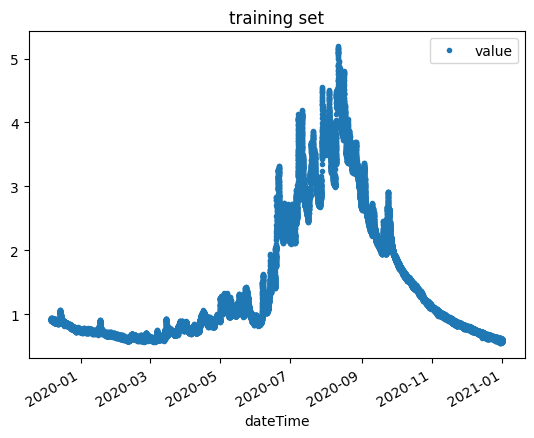

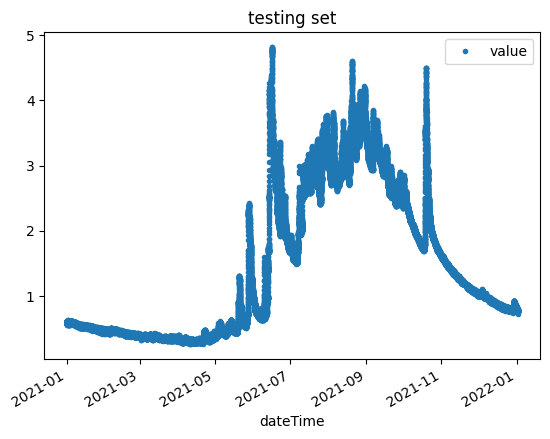

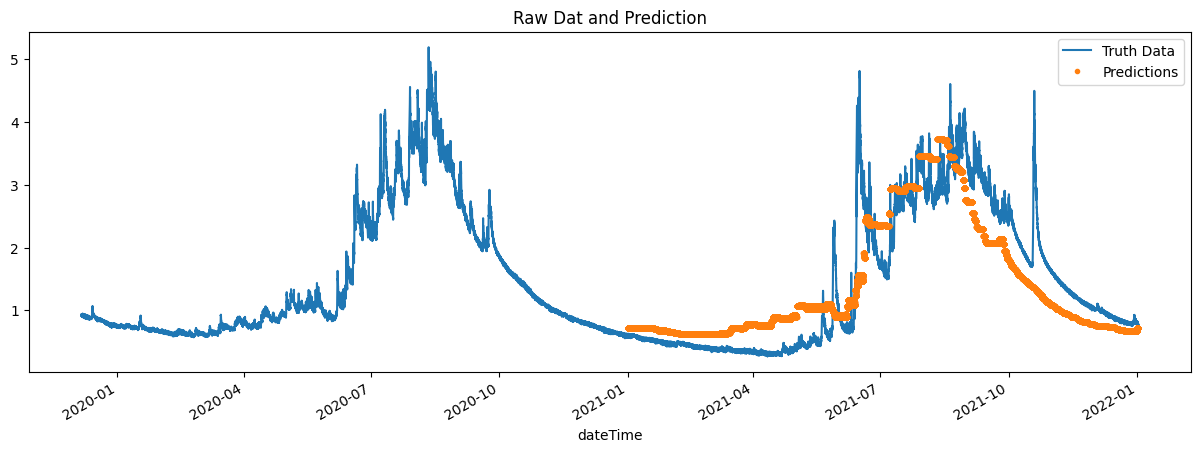

RMSE Score on Test set: 0.55


In [1]:
import calendar
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error


df = pd.read_csv('sanobheri_all.csv')

df = df.set_index('dateTime')
df.index = pd.to_datetime(df.index)
#df.plot(style='.',title='Water Level in m')

df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['value'].replace('',pd.np.nan)
df['value'].replace(' ',pd.np.nan)
df['value'] = df['value'].interpolate()

train=df.loc[df.index < '01-01-2021']
test=df.loc[df.index >= '01-01-2021']
train.plot(style='.',title='training set')
test.plot(style='.',title='testing set')
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'value'
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=10000,
                       early_stopping_rounds=100,
                       objective='reg:linear',
                       max_depth=4,
                       learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=300)


test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['value']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()
score = np.sqrt(mean_squared_error(test['value'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')



